(lecture15:cross-validation)=
# Cross validation for selecting the number of basis functions

In the previous section, we saw that the Fourier basis functions gave us a much better model for the motorcycle dataset.
But, how many basis functions should we choose?
To answer this question we are going to use a technique known as cross-validation.
The idea is simple.
Pick the number of basis functions that give you on average the smallest validation error.
By "validation" error, we mean the error on a subset of data not used in training.
By "average" we mean averaging over the possible ways in which you can split your dataset into training and validation.

Note that the validation dataset should be completely distinct from your test dataset.
So, it goes like this:

+ You split the original dataset into training and test subsets.
+ You repeatedly split the training subset into the subset you minimize the loss over and a validation subset.
+ For each candidate model, you evaluate the MSE on the validation subset and you average over all possible splits.
+ The model with the smallest MSE wins.

Let me demonstrate directly on the motorcycle data:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'svg')
import numpy as np
import scipy.stats as st
import pandas as pd
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

In [2]:
# The url of the motorcycle data:
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-297-intro-to-data-science/master/data/motor.dat'
# Download the data
download(url)
# Load the data
data = np.loadtxt('motor.dat')
# The inputs
x = data[:, 0]
# The outputs
y = data[:, 1]

Split into training and test:

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

The code for the Fourier design matrix:

In [4]:
def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    
        L           -       The "length" of the domain.
        num_terms   -       How many Fourier terms do you want. This is not the number
                            of basis functions you get. The number of basis functions
                            is 1 + num_terms / 2. The first one is a constant.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)

Now we are going to loop over different number of Fourier basis functions, and for each one of them we are going to repeatedly split the training dataset in two, train on the first half and calculate the MSE on the second half.
Here we go:

In [5]:
from sklearn.model_selection import RepeatedKFold

# This will hold the average MSE for each possible number of basis functions
MSE = []
fourier_L = 60.0
rkf = RepeatedKFold(n_splits=10, n_repeats=10)
for fourier_terms in range(1, 20):
    mse_sum = 0.0
    for train_index, valid_index in rkf.split(x_train):
        x_train_train, x_train_valid = x_train[train_index], x_train[valid_index]
        y_train_train, y_train_valid = y_train[train_index], y_train[valid_index]
        Phi_fourier_train = get_fourier_design_matrix(x_train_train[:, None], fourier_L, fourier_terms)
        w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train_train, rcond=None)
        Phi_fourier_valid = get_fourier_design_matrix(x_train_valid[:, None], fourier_L, fourier_terms)
        y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
        MSE_fourier = np.mean((y_valid_predict - y_train_valid) ** 2)
        mse_sum += MSE_fourier
    MSE.append(mse_sum / rkf.get_n_splits())

And here are the results:

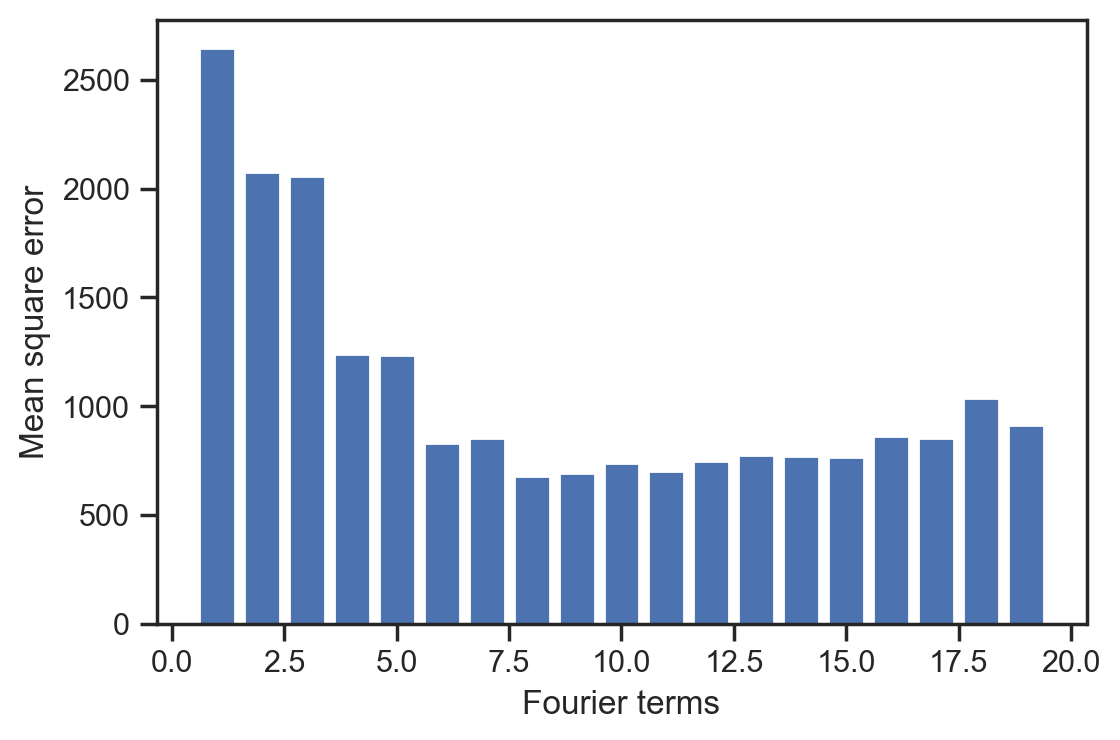

In [6]:
fig, ax = plt.subplots()
ax.bar(range(1, len(MSE)+1), MSE)
ax.set_xlabel('Fourier terms')
ax.set_ylabel('Mean square error');

So, the best number of basis functions is about 10.